In [1]:
from EmuLP import Cosmology, Filter, Galaxy, Estimator, Extinction, Template

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax_cosmo as jc
import jax.numpy as jnp
from jax import vmap, jit
import json, pickle
import os,sys,copy
from tqdm import tqdm
from collections import namedtuple

In [2]:
Cosmo = namedtuple('Cosmo', ['h0', 'om0', 'l0', 'omt'])
sedpyFilter = namedtuple('sedpyFilter', ['name', 'wavelengths', 'transmission'])
BaseTemplate = namedtuple('BaseTemplate', ['name', 'flux'])
Observation = namedtuple('Observation', ['num', 'AB_fluxes', 'AB_f_errors', 'z_spec'])
DustLaw = namedtuple('DustLaw', ['name', 'EBV', 'transmission'])

In [3]:
conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC.json' # attention à la localisation du fichier !
with open(conf_json, "r") as inpfile:
    inputs = json.load(inpfile)

#cosmo = Cosmology.make_jcosmo(inputs['Cosmology']['h0'])
cosmo = Cosmo(inputs['Cosmology']['h0'], inputs['Cosmology']['om0'], inputs['Cosmology']['l0'],\
              inputs['Cosmology']['om0']+inputs['Cosmology']['l0'])

z_grid = jnp.arange(inputs['Z_GRID']['z_min'],\
                    inputs['Z_GRID']['z_max']+inputs['Z_GRID']['z_step'],\
                    inputs['Z_GRID']['z_step'])
wl_grid = jnp.arange(inputs['WL_GRID']['lambda_min'],\
                     inputs['WL_GRID']['lambda_max']+inputs['WL_GRID']['lambda_step'],\
                     inputs['WL_GRID']['lambda_step'])

print("Loading filters :")
filters_dict = inputs['Filters']
filters_arr = tuple( sedpyFilter(*Filter.load_filt(filters_dict[ident]["name"],\
                                                   filters_dict[ident]["path"],\
                                                   filters_dict[ident]["transmission"]\
                                                  )\
                                )
                    for ident in tqdm(filters_dict) )
N_FILT = len(filters_arr)

print("Building templates :")
templates_dict = inputs['Templates']
baseTemp_arr = tuple( BaseTemplate(*Template.make_base_template(templates_dict[ident]["name"],\
                                                                templates_dict[ident]["path"],\
                                                                wl_grid
                                                               )\
                                  )
                     for ident in tqdm(templates_dict) )

#baseFluxes_arr = jnp.row_stack((bt.flux for bt in baseTemp_arr))

print("Generating dust attenuations laws :")
extlaws_dict = inputs['Extinctions']
dust_arr = []
for ident in tqdm(extlaws_dict):
    dust_arr.extend([ DustLaw(extlaws_dict[ident]['name'],\
                                 ebv,\
                                 Extinction.load_extinc(f'{ident}_{ebv}',\
                                                        extlaws_dict[ident]['path'],\
                                                        ebv,\
                                                        wl_grid)\
                                )\
                        for ebv in tqdm(inputs['e_BV'])\
                       ])

#extlaws_arr = jnp.row_stack( (dustlaw.transmission for dustlaw in dust_arr) )

print("Loading observations :")
data_path = os.path.abspath(inputs['Dataset']['path'])
data_ismag = (inputs['Dataset']['type'].lower() == 'm')

data_file_arr = np.loadtxt(data_path)
_obs_arr = []

for i in tqdm(range(data_file_arr.shape[0])):
    try:
        assert (len(data_file_arr[i,:]) == 1+2*N_FILT) or (len(data_file_arr[i,:]) == 1+2*N_FILT+1), f"At least one filter is missing in datapoint {data_file_arr[i,0]} : length is {len(data_file_arr[i,:])}, {1+2*N_FILT} values expected.\nDatapoint removed from dataset."
        #print(int(data_file_arr[i, 0]))
        if (len(data_file_arr[i,:]) == 1+2*N_FILT+1):
            observ = Observation(int(data_file_arr[i, 0]),\
                                 *Galaxy.load_galaxy(data_file_arr[i, 1:2*N_FILT+1],\
                                                     data_ismag),\
                                 data_file_arr[i, 2*N_FILT+1]\
                                )
        else:
            observ = Observation(int(data_file_arr[i, 0]),\
                                 *Galaxy.load_galaxy(data_file_arr[i, 1:2*N_FILT+1],\
                                                     data_ismag),\
                                 None\
                                )
        #print(observ.num)
        _obs_arr.extend([observ])
    except AssertionError:
        pass

Loading filters :


100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


Building templates :


100%|██████████| 18/18 [00:03<00:00,  5.20it/s]


Generating dust attenuations laws :


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Loading observations :


100%|██████████| 5000/5000 [00:02<00:00, 1760.31it/s]


In [4]:
df_res = pd.read_pickle(f"{inputs['run name']}_results.pkl")

In [5]:
df_res

,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2
9746,0.70,0.7461,CWW_Im-id699,Calzetti,0.50,22.329861
17274,0.34,0.3453,AVG_CLUST_KIN_Sb,Prevot,0.10,91.773064
16066,0.28,0.4743,CWW_Scd-id532,Prevot,0.10,71.928383
15534,1.33,1.3549,KIN_Sb-id497,Calzetti,0.00,34.461960
288,0.31,0.3641,AVG_CLUST_CWW_Scd,Calzetti,0.05,45.292934
...,...,...,...,...,...,...
963,0.58,0.6610,CWW_Im-id699,Prevot,0.35,31.357239
13575,0.61,0.6690,AVG_CLUST_CWW_Sbc,Calzetti,0.25,19.784458
16677,0.67,0.8107,AVG_CLUST_CWW_Scd,Prevot,0.25,27.801331
1290,0.31,0.5549,AVG_CLUST_CWW_Im,Calzetti,0.20,50.671867


In [6]:
for obs in tqdm(_obs_arr):
    for i,filt in enumerate(filters_arr):
        if obs.num in df_res.index:
            df_res.loc[obs.num, f"MagAB({filt.name})"] = -2.5*jnp.log10(obs.AB_fluxes[i])-48.6
            df_res.loc[obs.num, f"err_MagAB({filt.name})"] = 1.086*obs.AB_f_errors[i]/obs.AB_fluxes[i]

100%|██████████| 5000/5000 [01:38<00:00, 50.75it/s]


In [7]:
df_res['G-R'] = df_res['MagAB(hsc_gHSC)']-df_res['MagAB(hsc_rHSC)']
df_res['I-Z'] = df_res['MagAB(hsc_iHSC)']-df_res['MagAB(hsc_zHSC)']
df_res['redness'] = df_res['G-R']/df_res['I-Z']
df_res

,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,MagAB(cosmos_u_cfht),err_MagAB(cosmos_u_cfht),MagAB(cosmos_u_new),err_MagAB(cosmos_u_new),...,err_MagAB(hsc_rHSC),MagAB(hsc_iHSC),err_MagAB(hsc_iHSC),MagAB(hsc_zHSC),err_MagAB(hsc_zHSC),MagAB(hsc_yHSC),err_MagAB(hsc_yHSC),G-R,I-Z,redness
9746,0.70,0.7461,CWW_Im-id699,Calzetti,0.50,22.329861,24.417412,0.011633,24.348366,0.021263,...,0.013506,22.775993,0.008660,22.565758,0.009436,22.445854,0.011657,0.588097,0.210236,2.797322
17274,0.34,0.3453,AVG_CLUST_KIN_Sb,Prevot,0.10,91.773064,22.303703,0.004022,22.426910,0.007625,...,0.003046,19.121391,0.002095,18.793785,0.002087,18.647423,0.002202,1.320465,0.327606,4.030647
16066,0.28,0.4743,CWW_Scd-id532,Prevot,0.10,71.928383,23.659966,0.007216,23.652161,0.008654,...,0.007059,21.826317,0.005374,21.662148,0.005901,21.348351,0.006208,0.928139,0.164169,5.653546
15534,1.33,1.3549,KIN_Sb-id497,Calzetti,0.00,34.461960,25.812943,0.081933,25.988327,0.157344,...,0.013792,21.466805,0.005894,20.739624,0.004870,19.995567,0.003941,1.264076,0.727180,1.738325
288,0.31,0.3641,AVG_CLUST_CWW_Scd,Calzetti,0.05,45.292934,23.699928,0.019513,23.724022,0.024347,...,0.008031,22.027412,0.006589,21.740891,0.006840,21.743980,0.009090,0.772926,0.286522,2.697617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,0.58,0.6610,CWW_Im-id699,Prevot,0.35,31.357239,25.474510,0.035866,25.312149,0.037729,...,0.023974,24.132362,0.017961,24.127434,0.024282,24.132553,0.042866,0.581917,0.004929,118.069659
13575,0.61,0.6690,AVG_CLUST_CWW_Sbc,Calzetti,0.25,19.784458,23.546188,0.018358,23.534241,0.033199,...,0.011195,21.055595,0.006106,20.550385,0.005634,20.360817,0.006274,0.983696,0.505211,1.947100
16677,0.67,0.8107,AVG_CLUST_CWW_Scd,Prevot,0.25,27.801331,24.415054,0.015000,24.340652,0.015525,...,0.010263,21.894165,0.005891,21.578720,0.005997,21.421211,0.006900,0.822662,0.315445,2.607943
1290,0.31,0.5549,AVG_CLUST_CWW_Im,Calzetti,0.20,50.671867,22.355522,0.002543,22.414856,0.003255,...,0.004670,20.873199,0.003577,20.741928,0.003942,20.565590,0.004259,0.696503,0.131271,5.305824


<AxesSubplot:xlabel='G-R', ylabel='I-Z'>

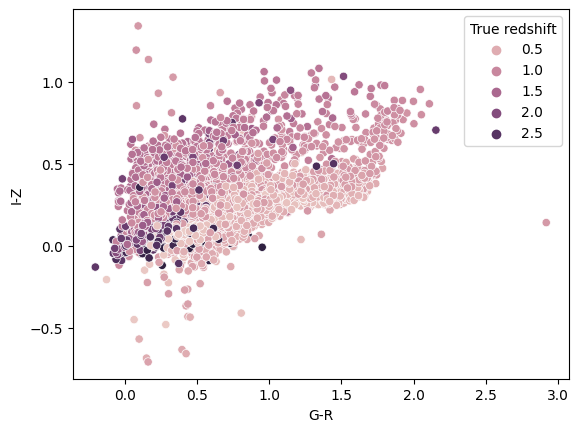

In [8]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='G-R', y='I-Z', hue='True redshift', ax=a)

<AxesSubplot:xlabel='G-R', ylabel='I-Z'>

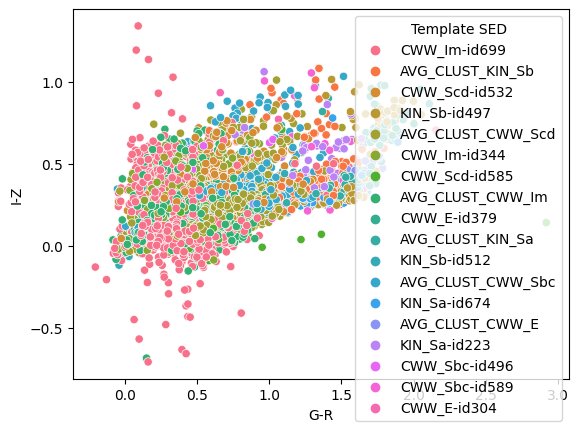

In [9]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='G-R', y='I-Z', hue='Template SED', ax=a)

(0.0, 3.0)

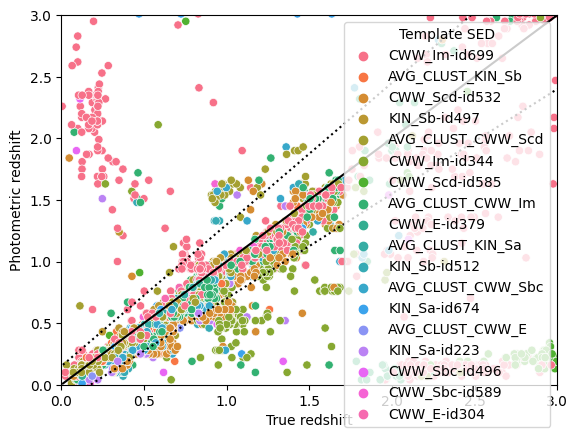

In [10]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='True redshift', y='Photometric redshift', hue='Template SED', ax=a)
a.plot(z_grid, z_grid, c='k')
a.plot(z_grid, 0.15+1.15*z_grid, c='k', ls=':')
a.plot(z_grid, -0.15+0.85*z_grid, c='k', ls=':')
a.set_xlim(0.,3.0)
a.set_ylim(0.,3.0)

In [11]:
with open(f"{inputs['run name']}_results_dicts.pkl", 'rb') as handle:
    results_dict=pickle.load(handle)

In [12]:
keys = [key for key in results_dict.keys()]
_ex_=keys[0]
zps=z_grid

In [13]:
key_0=_ex_
_dict_0=results_dict[key_0]
_dict_0

DeviceArray([[[ 245.34338,  259.30692,  269.3054 , ..., 2413.7053 ,
               2327.6194 , 2250.1165 ],
              [ 231.50522,  268.71732,  293.4035 , ..., 1810.355  ,
               1738.8024 , 1675.6146 ],
              [ 263.8827 ,  319.21353,  355.80103, ..., 1287.8708 ,
               1238.9579 , 1197.1239 ],
              ...,
              [ 616.11975,  697.79694,  752.28296, ..., 2114.4412 ,
               2143.9355 , 2173.225  ],
              [ 707.60095,  790.16144,  845.7863 , ..., 2411.107  ,
               2437.9658 , 2464.9822 ],
              [ 899.30646,  978.88226, 1033.8741 , ..., 2930.9116 ,
               2955.5623 , 2980.7986 ]],

             [[ 719.6251 ,  809.3783 ,  848.6099 , ..., 1783.5294 ,
               1733.1515 , 1693.54   ],
              [ 815.6669 ,  906.2969 ,  948.8855 , ..., 1189.957  ,
               1157.8656 , 1135.1738 ],
              [ 922.2126 , 1011.45905, 1056.138  , ...,  751.1755 ,
                741.51306,  738.8794 ],
       

In [14]:
_zps = np.array([])
chi2s = np.array([])
modids = np.array([])
extlaws = np.array([])
ebvs = np.array([])

for i,mod in enumerate(baseTemp_arr):
    for j, dust in enumerate(dust_arr):
        _zps = np.append(_zps, z_grid)
        chi2s = np.append(chi2s, _dict_0[i, j, :])
        modids = np.append(modids, np.full(z_grid.shape, mod.name))
        extlaws = np.append(extlaws, np.full(z_grid.shape, dust.name))
        ebvs = np.append(ebvs, np.full(z_grid.shape, dust.EBV))

dict_0 = {}
dict_0['zp'] = _zps
dict_0['chi2'] = chi2s
dict_0['mod id'] = modids
dict_0['ext law'] = extlaws
dict_0['eBV'] = ebvs

In [15]:
df0 = pd.DataFrame(dict_0)
df0

,zp,chi2,mod id,ext law,eBV
0,0.01,245.343384,AVG_CLUST_CWW_Sbc,Calzetti,0.0
1,0.04,259.306915,AVG_CLUST_CWW_Sbc,Calzetti,0.0
2,0.07,269.305389,AVG_CLUST_CWW_Sbc,Calzetti,0.0
3,0.10,266.666290,AVG_CLUST_CWW_Sbc,Calzetti,0.0
4,0.13,259.181793,AVG_CLUST_CWW_Sbc,Calzetti,0.0
...,...,...,...,...,...
36355,2.89,4973.408203,KIN_Sa-id674,Prevot,0.5
36356,2.92,4884.912109,KIN_Sa-id674,Prevot,0.5
36357,2.95,4829.587402,KIN_Sa-id674,Prevot,0.5
36358,2.98,4806.467773,KIN_Sa-id674,Prevot,0.5


<AxesSubplot:xlabel='zp', ylabel='chi2'>

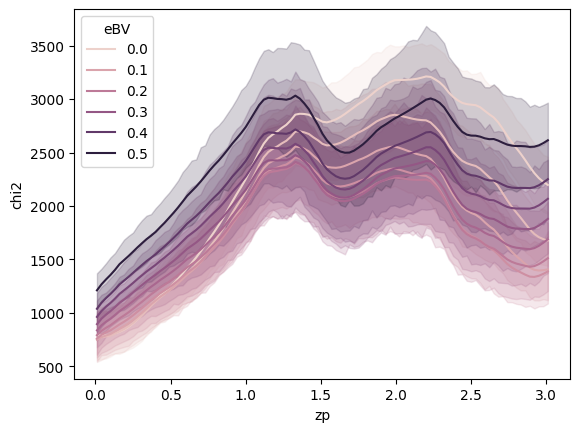

In [16]:
sns.lineplot(data=df0, x='zp', y='chi2', hue='eBV')

In [17]:
_sel = (df0['mod id']==df_res.loc[key_0,'Template SED']) * (df0['ext law']==df_res.loc[key_0,'Extinction law'])
df00 = df0[_sel]
df000 = df00[df00['chi2']<1000000]

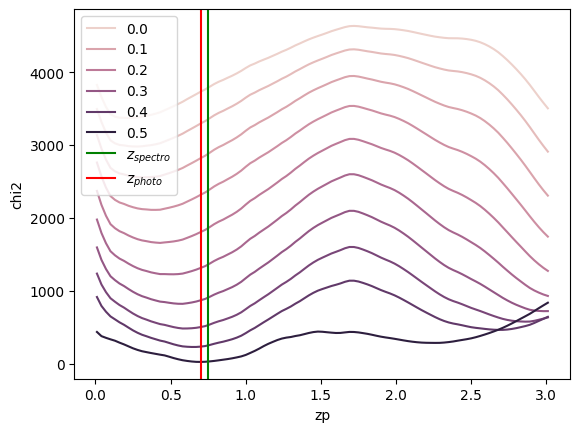

In [18]:
f,a = plt.subplots(1,1)
sns.lineplot(data=df000, x='zp', y='chi2', hue='eBV', ax=a)
a.axvline(df_res.loc[key_0, 'True redshift'], c='green', label="$z_{spectro}$")
a.axvline(df_res.loc[key_0, 'Photometric redshift'], c='red', label="$z_{photo}$")
a.legend()

In [19]:
chi_arr_mod = np.column_stack([df00[df00['eBV']==val]['chi2'].values\
                               for val in np.unique(df00['eBV'].values)]) # if 'CWW' in mod])

In [20]:
chi_arr_mod.shape

(101, 10)

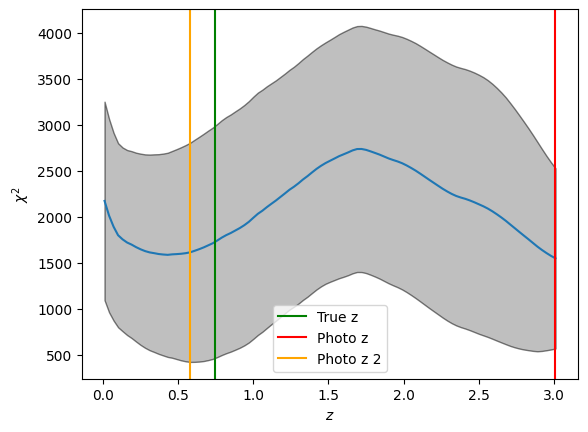

In [21]:
f,a = plt.subplots(1,1)
chi_avg = np.average(chi_arr_mod, axis=1)
chi_std = np.std(chi_arr_mod, axis=1)
a.plot(zps, chi_avg)
a.fill_between(x=zps, y1=np.fmax(np.ones_like(chi_avg), chi_avg-chi_std), y2=chi_avg+chi_std, alpha=0.5, facecolor='grey', edgecolor='k')
a.axvline(df_res.loc[key_0, 'True redshift'], label='True z', c='g')
a.axvline(zps[np.nanargmin(chi_avg)], label='Photo z', c='r')
a.axvline(zps[np.nanargmin(chi_avg-chi_std)], label='Photo z 2', c='orange')
a.set_xlabel('$z$')
a.set_ylabel('$\chi^2$')
a.legend()

OK donc c'est pas complètement sans espoir ! Il faudrait intégrer la visualisation de ces résultats dans un dash maintenant...

In [22]:
if False:
    df_temp_prop = pd.read_pickle('COSMOS2020-with-FORS2-HSC_only-jaxcosmo_templates_properties.pkl')
    df_temp_prop

In [23]:
if False:
    np.power(10., -0.4*(df_temp_prop.loc[0,'Mag(cosmos_u_new)'] +48.6))

Smail distribution : $n(z) = z^{a}\mathrm{e}^{-\left(\frac{z}{z_0}\right)^{b}}$

In [24]:
smail_z1 = jc.redshift.smail_nz(1., 2.,  1., zmax=3.) # a=1, b=2, z0=1

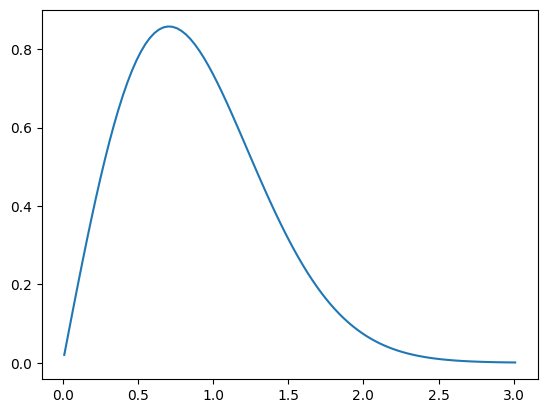

In [25]:
plt.plot(zps, smail_z1(zps))

In [26]:
np.trapz(smail_z1(zps), zps)

0.9997569

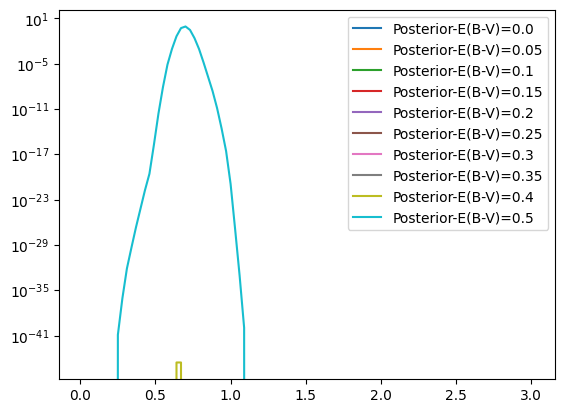

In [27]:
chimin=jnp.nanmin(jnp.array(df000['chi2']))
for val in np.unique(df000['eBV']):
    _sel = (df000['eBV'] == val)
    prior = smail_z1(jnp.array(df000['zp'][_sel]))
    newchi = jnp.array(df000['chi2'][_sel]-chimin)-2*jnp.log(prior)
    dist = jnp.exp(-0.5*newchi)
    norm = jnp.trapz(dist, jnp.array(df000['zp'][_sel]))
    plt.plot(df000['zp'][_sel], dist, label=f"Posterior-E(B-V)={val}")
plt.legend()
plt.yscale('log')

## LEPHARE prior on N(z)
Based on [z-VVDS](https://cesam.lam.fr/vvds/)

### Construct the filters

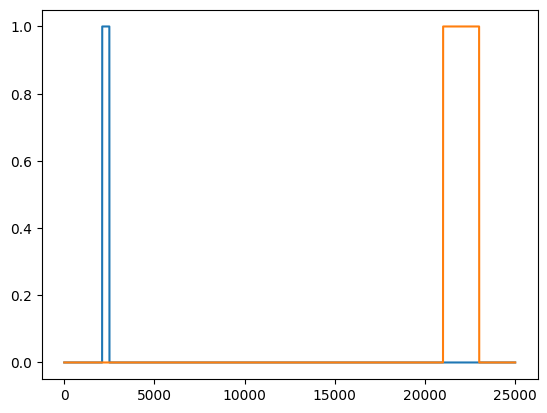

In [28]:
# NUV
nuv_transm = np.zeros_like(wl_grid)
nuv_transm[(wl_grid>=2100.)*(wl_grid<=2500.0)] = 1.0
NUV_filt = sedpyFilter("NUV", wl_grid, nuv_transm)

# NIR
nir_transm = np.zeros_like(wl_grid)
nir_transm[(wl_grid>=21000.)*(wl_grid<=23000.0)] = 1.0
NIR_filt = sedpyFilter("NIR", wl_grid, nir_transm)

plt.plot(wl_grid, nuv_transm)
plt.plot(wl_grid, nir_transm)

### Define the NUV-R rest-frame color corrected for dust-extinction

In [29]:
basetempl = [ bt for bt in baseTemp_arr if bt.name == df_res.loc[key_0,'Template SED'] ][0]
extlaw = [ dust for dust in dust_arr if (dust.name == df_res.loc[key_0, 'Extinction law'])\
                                          and (dust.EBV == df_res.loc[key_0, 'E(B-V)']) ][0]
                
obs = [ _obs for _obs in _obs_arr if _obs.num == key_0 ][0]
lnuv, lnir = jnp.array([Filter.ab_mag(filt.wavelengths, filt.transmission,\
                                        wl_grid, basetempl.flux*extlaw.transmission)\
                          for filt in (NUV_filt, NIR_filt)])
#nuv_nir_fluxes = jnp.power(10, -0.4*(nuv_nir_mags+48.6))
#lnuv, lnir = jnp.log10(nuv_nir_fluxes)
nuvk = lnuv-lnir #-2.5*(lnuv-lnir)
nuvk

DeviceArray(2.3747396, dtype=float32)

### Define the prior in function of nuvk and Mag(i)
Pb : qui est 'red'? - c'est le redshift de la SED.

In [30]:
def nz_prior(z, nuvk, i_mag):
    val = 0.
    #if not ((i_mag<22. and z>2.) or (i_mag<20. and z>1.)):
    # Set up the parameters to define the redshift distribution
    if (nuvk>4.25):
        # Case E/S0
        # Color UV-K of PHOTO_230506/El_cww.sed.resample.new.resample15.inter 
        mod = 0
        zot = 0.45181
        kt = 0.13677
        alpt0 = 3.33078
        pcal = 0.89744
    elif (nuvk>3.19 and nuvk<4.25):
        # Case Sbc
        # Color UV-K of PHOTO_230506/Sbc_cww.sed.resample.new.resample8.inter 
        mod  = 1
        zot  = 0.16560
        kt   = 0.12983 
        alpt0= 1.42815
        pcal=  0.90868
    elif (nuvk>1.9 and nuvk<3.19):
        # Case Scd
        # Color UV-K of PHOTO_230506/Scd_cww.sed.resample.new.resample7.inter  -19.4878 + 21.1501
        mod  = 2
        zot  = 0.21072
        kt   = 0.14008
        alpt0= 1.58310
        pcal=  0.89747
    else:
        # Case Irr
        mod  = 3
        zot  = 0.20418
        kt   = 0.13773 
        alpt0= 1.34500
        pcal=  0.91760

    # P(z|T,m0)
    kk = max((i_mag-20), 0)
    zmax = zot + kt*kk
    pz = jnp.power(z,alpt0)*jnp.exp(-jnp.power((z/zmax),alpt0))

    # P(T|m0)
    ktf = jnp.array([0.47165, 0.30663, 0.12715, -0.34437])
    ft = jnp.array([0.43199, 0.07995, 0.31162, 0.21220])

    # Ratio for each type
    rappSum = jnp.sum(ft*jnp.exp(-ktf*kk))
    rapp = ft[mod]*jnp.exp(-ktf[mod]*kk)

    # Normalisation of the probability function
    pcal=jnp.power(zmax,alpt0+1)/alpt0*pcal

    # Final value
    val = pz / pcal * rapp/rappSum
    return val

In [31]:
P_prior = nz_prior(df_res.loc[key_0, 'Photometric redshift'], nuvk, df_res.loc[key_0, 'MagAB(hsc_iHSC)'])
P_prior

DeviceArray(0.24883461, dtype=float32)

In [32]:
from functools import partial

@partial(vmap, in_axes=(0,None,None))
def vect_nz_prior(z, nuvk, i_mag):
    return nz_prior(z, nuvk, i_mag)

In [33]:
grid_prior = vect_nz_prior(z_grid, float(nuvk), df_res.loc[key_0, 'MagAB(hsc_iHSC)'])

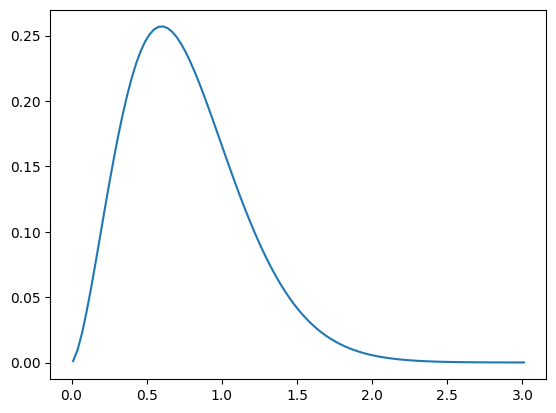

In [34]:
plt.plot(z_grid, grid_prior)

Text(0, 0.5, '$P(z|T, m_{AB}(i))$')

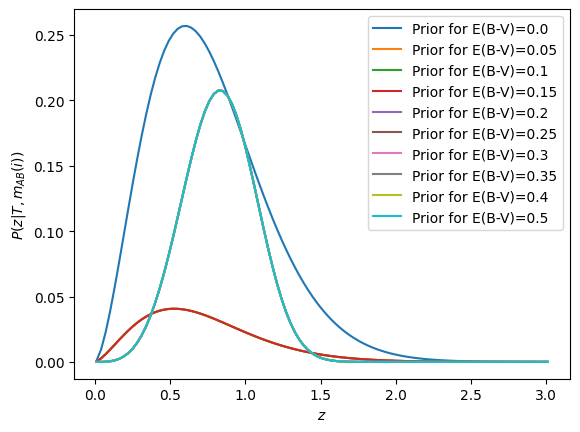

In [35]:
f,a = plt.subplots(1,1)
basetempl = baseTemp_arr[ [bt.name == df_res.loc[key_0,'Template SED'] for bt in baseTemp_arr][0] ]
extlaw = [ law for law in dust_arr if law.name==df_res.loc[key_0, 'Extinction law'] ]
obs = _obs_arr[ [_obs.num == key_0 for _obs in _obs_arr][0] ]
for law in extlaw:
    lnuv, lnir = jnp.array([Filter.ab_mag(filt.wavelengths, filt.transmission,\
                                            wl_grid, basetempl.flux*law.transmission)\
                              for filt in (NUV_filt, NIR_filt)])
    nuvk = lnuv-lnir
    grid_prior = vect_nz_prior(z_grid, nuvk, df_res.loc[key_0, 'MagAB(hsc_iHSC)'])
    a.plot(z_grid, grid_prior, label=f"Prior for E(B-V)={law.EBV}")
a.legend()
a.set_xlabel("$z$")
a.set_ylabel("$P(z|T, m_{AB}(i))$")

[DustLaw(name='Calzetti', EBV=0.5, transmission=DeviceArray([0.        , 0.        , 0.        , ..., 0.9132145 ,
             0.91323894, 0.9132633 ], dtype=float32))]


Text(0, 0.5, '$P(z|T, m_{AB}(i))$')

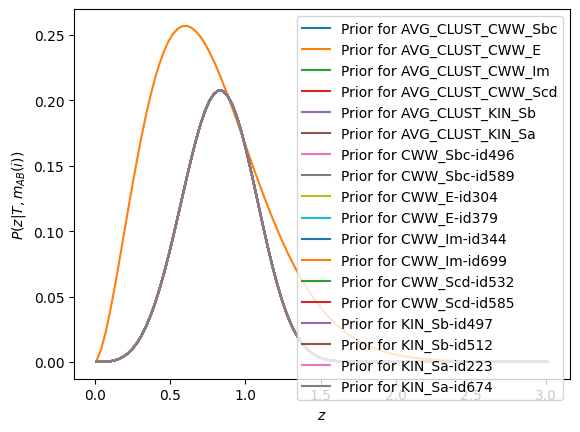

In [36]:
f,a = plt.subplots(1,1)
#basetempl = baseTemp_arr[ [bt.name == df_res.loc[key_0,'Template SED'] for bt in baseTemp_arr][0] ]
extlaw = [ law for law in dust_arr if law.name==df_res.loc[key_0, 'Extinction law'] ]
extlaw = [ law for law in extlaw if law.EBV==df_res.loc[key_0, 'E(B-V)'] ]
print(extlaw)
law=extlaw[0]
obs = _obs_arr[ [_obs.num == key_0 for _obs in _obs_arr][0] ]
for basetempl in baseTemp_arr:
    lnuv, lnir = jnp.array([Filter.ab_mag(filt.wavelengths, filt.transmission,\
                                            wl_grid, basetempl.flux*law.transmission)\
                              for filt in (NUV_filt, NIR_filt)])
    nuvk = lnuv-lnir
    grid_prior = vect_nz_prior(z_grid, nuvk, df_res.loc[key_0, 'MagAB(hsc_iHSC)'])
    a.plot(z_grid, grid_prior, label=f"Prior for {basetempl.name}")
a.legend()
a.set_xlabel("$z$")
a.set_ylabel("$P(z|T, m_{AB}(i))$")

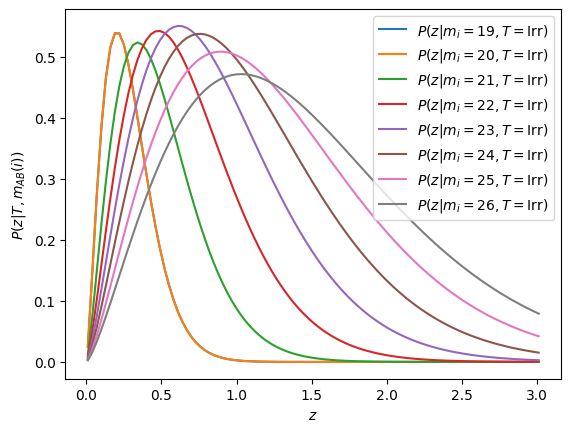

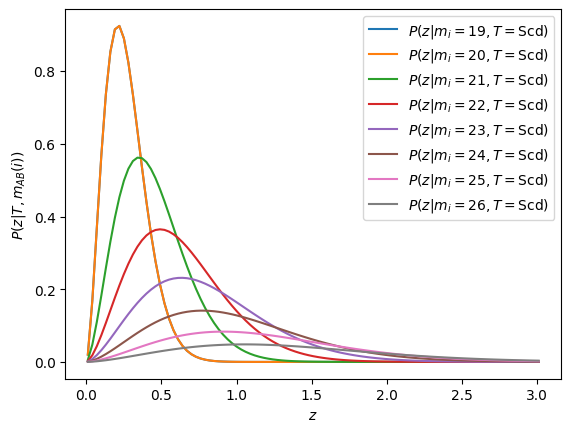

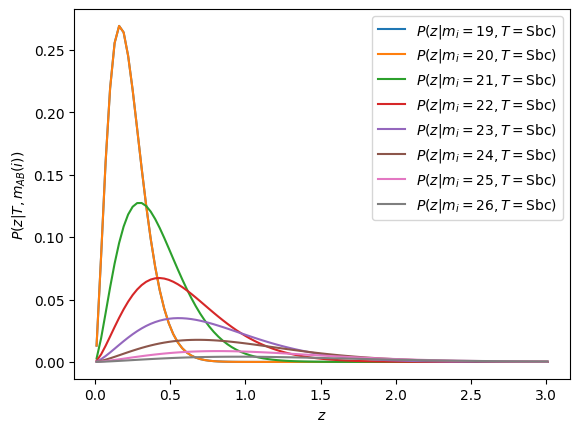

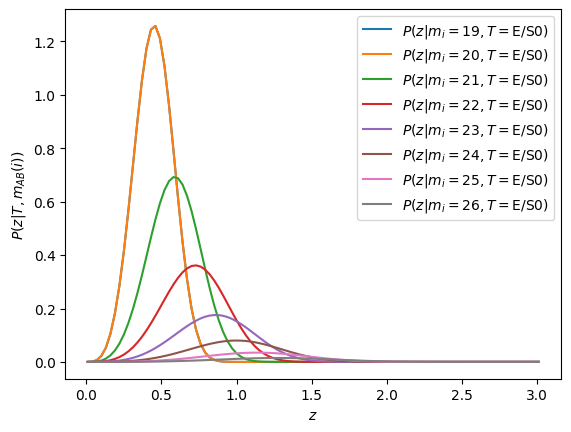

In [37]:
typNUV_dict = { 'Irr':1.5, 'Scd':2.5, 'Sbc':3.5, 'E/S0':4.5 }
for typ in typNUV_dict:
    f,a = plt.subplots(1,1)
    for magi in range(19, 27, 1):
        grid_prior = vect_nz_prior(z_grid, typNUV_dict[typ], magi)
        a.plot(z_grid, grid_prior, label=f"$P(z|m_i=${magi}$, T=${typ}$)$")
    a.legend()
    a.set_xlabel("$z$")
    a.set_ylabel("$P(z|T, m_{AB}(i))$")

In [38]:
PriorParams = namedtuple('PriorParams', ['mod', 'zot', 'kt', 'alpt0', 'pcal', 'nuv_range'])

prior_params_set = (PriorParams(0, 0.45181, 0.13677, 3.33078, 0.89744, (4.25, jnp.inf)),\
                    PriorParams(1, 0.16560, 0.12983, 1.42815, 0.90868, (3.19, 4.25)),\
                    PriorParams(2, 0.21072, 0.14008, 1.58310, 0.89747, (1.9, 3.19)),\
                    PriorParams(3, 0.20418, 0.13773, 1.34500, 0.91760, (-jnp.inf, 1.9)),\
                   )

prior_pars_E_S0, prior_pars_Sbc, prior_pars_Scd, prior_pars_Irr = prior_params_set

@jit
@vmap
def prior_zot(nuvk):
    val = prior_pars_Irr.zot +\
            (prior_pars_Scd.zot - prior_pars_Irr.zot)*jnp.heaviside(nuvk-prior_pars_Scd.nuv_range[0], 0)+\
            (prior_pars_Sbc.zot - prior_pars_Scd.zot)*jnp.heaviside(nuvk-prior_pars_Sbc.nuv_range[0], 0)+\
            (prior_pars_E_S0.zot - prior_pars_Sbc.zot)*jnp.heaviside(nuvk-prior_pars_E_S0.nuv_range[0], 0)
    return val

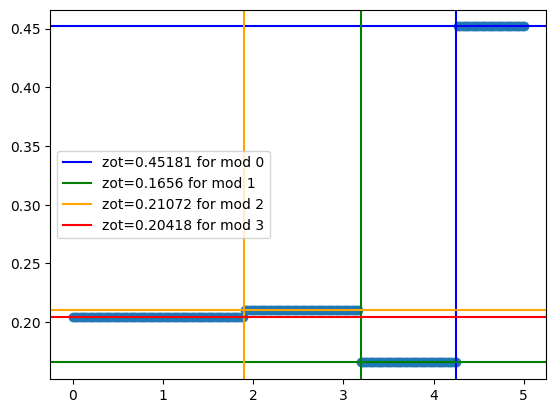

In [39]:
f,a = plt.subplots(1,1)
nuvrange = jnp.linspace(0., 5., 200)
a.scatter(nuvrange, prior_zot(nuvrange))
for pparams, cl in zip(prior_params_set, ['blue', 'green', 'orange', 'red']):
    if pparams.mod<3:
        a.axvline(pparams.nuv_range[0], c=cl)
    a.axhline(pparams.zot, c=cl, label=f"zot={pparams.zot} for mod {pparams.mod}")
a.legend()